# HCR-Net 
An implementation of the paper: "Chauhan, V. K., Singh, S., & Sharma, A. (2022). 
HCR-Net: A deep learning based script independent handwritten character recognition network. arXiv preprint arXiv:2108.06663."

@author:
    Vinod Kumar Chauhan,
    Department of Engineering,
    University of Oxford, UK
    Email id: jmdvinodjmd@gmail.com / vinod.kumar@eng.ox.ac.uk

Created on: June 2021, Last modified on: August, 2022.

### HCR-Net (with image-augmentation)

2022-08-30 23:48:30.936898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

2022-08-30 23:49:13.358331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-30 23:49:13.482458: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 45s 82ms/step - loss: 0.1029 - accuracy: 0.9686 - val_loss: 0.0067 - val_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 2/10
531/531 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9938

2022-08-30 23:49:56.795972: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-30 23:49:56.927750: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 44s 82ms/step - loss: 0.0226 - accuracy: 0.9938 - val_loss: 0.0047 - val_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 3/10
531/531 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

2022-08-30 23:50:41.371528: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


531/531 [==============================] - 44s 83ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0045 - val_accuracy: 0.9987 - lr: 1.0000e-04
Epoch 4/10
531/531 [==============================] - 42s 79ms/step - loss: 0.0119 - accuracy: 0.9969 - val_loss: 0.0036 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 5/10
531/531 [==============================] - 42s 79ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0028 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 6/10
531/531 [==============================] - 42s 79ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0024 - val_accuracy: 0.9993 - lr: 5.0000e-05
Epoch 7/10
531/531 [==============================] - 42s 79ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.0033 - val_accuracy: 0.9990 - lr: 5.0000e-05
Epoch 8/10
531/531 [==============================] - 42s 79ms/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 9.7141e-04 - val_accuracy: 0.9997 - lr: 5.0000e-05
Epoch 9/10
531/531 [=====================

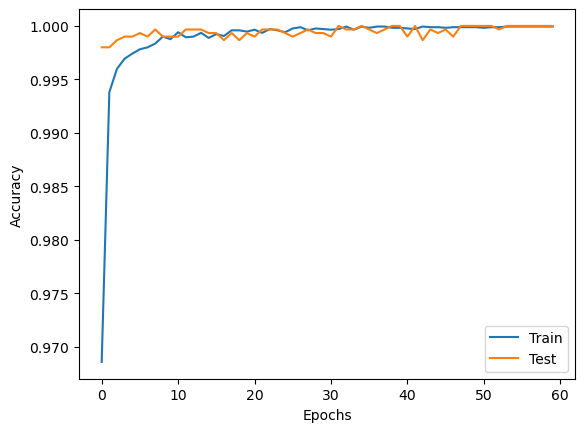

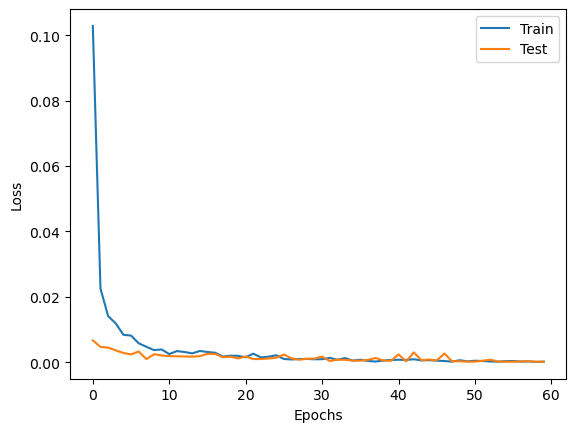

1/1 [==============================] - 4s 4s/step


Text(0.5, 14.581597222222216, 'Predicted Class')

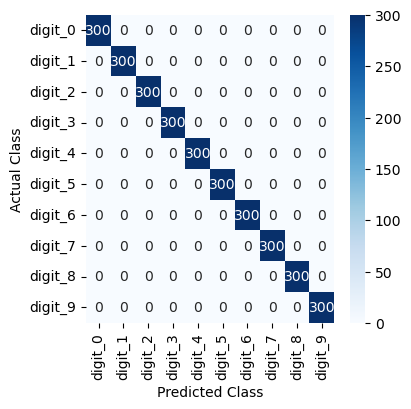

In [1]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
nb_train_samples = 17000
nb_validation_samples = 3000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

# set seeds for reproduceability
np.random.seed(1)
tf.random.set_seed(1)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create a new model using lower layers of VGG16 upto block4_conv2,
# and mark as not trainable, i.e., freeze the lower layers
model = Sequential()
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained VGG16
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load, augment and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0
                )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    color_mode="rgb",
                    class_mode='categorical',
                    shuffle=True,
                    seed=13)
validation_generator = test_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=nb_validation_samples,
                    color_mode="rgb",
                    shuffle=False,
                    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-Aug-I.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback],
                validation_data=validation_generator,
                validation_steps=1)

# save the model
model.save_weights('./results/HCR-Net-Aug-II.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
##############################################################################

In [2]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  1.0
recall_score   :  1.0
f1_score       :  1.0
accuracy_score :  1.0

Best accuracy  :  1.0
